In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchxai.base import XaiBase, XaiHook, XaiModel
from collections import OrderedDict
from src.models import CnnMnist, ResNetMnist, ResNetMnistCBAM, ResNetMnistANR, ResNetCifar10, ResNetCifar10CBAM, ResNetCifar10ANR
from torchxai.model import VanillaGrad
import matplotlib.pyplot as plt

In [2]:
from src.trainsettings import ModelTranier
from src.utils import argument_parsing

In [3]:
from pathlib import Path

In [5]:
from src.utils import argument_parsing, Explorer

mnist_parser = argument_parsing(preparse=True)
mnist_args_string = \
"""-pp  ../XAI
-dp  ../data
-rf  mnist-resnetsmall-kar-eval
-dt  mnist
-et  kar
-at  random  vanillagrad  inputgrad  guidedgrad  gradcam
-mt  resnet  resnetcbam  resnetanr
-bs  256
-ns  10
-down""".replace("\n", "  ").split("  ")
mnist_args = mnist_parser.parse_args(mnist_args_string)

cifar10_parser = argument_parsing(preparse=True)
cifar10_args_string = \
"""-pp  ../XAI
-dp  ../data
-rf  cifar10-resnetsmall-roar-eval
-dt  cifar10
-et  roar
-at  random  vanillagrad  inputgrad  guidedgrad  gradcam
-mt  resnet  resnetcbam  resnetanr
-bs  256
-ns  30
-down""".replace("\n", "  ").split("  ")
cifar10_args = cifar10_parser.parse_args(cifar10_args_string)

In [6]:
torch.manual_seed(args.seed)
train_dataset, test_dataset, train_loader1, test_loader1 = trainer.build_dataset(args, shuffle=False)

In [7]:
m_type = "resnet"
a_type = "vanillagrad"
load_path = "trained/cifar10/roar/resnet-first.pt"
model_class = trainer.model_dict[args.data_type][m_type]
attr_class = trainer.attr_dict[a_type]
# attr_class = GradCAM
attr_kwargs = trainer.get_kwargs_to_attr_model(args.data_type, m_type, a_type)
model, attr_model = trainer.create_attr_model(model_class, attr_class, load_path, attr_kwargs)
# model = ResNetMnist()
# attr_model = trainer.attr_dict[a_type](model)

In [10]:
for datas, targets in test_loader1:
    break
print(attr_model.model.training)
a = attr_model._one_hot(targets, module_name="fc")
print(a.size())

False
torch.Size([256, 10])


## Test for fill global mean and roar/kar

In [ ]:
cifar10_args.fill_global_mean = True
cifar10_args.eval_type = "kar"
datas = torch.load("./trained/cifar10/roar/plain/cifar10-test.data") # (B, C, H, W)
masks = torch.load("./trained/cifar10/roar/plain/resnet-vanillagrad-test-0.9.masks")  # (B, C, H, W)
new_datas = explorer.fill_datas_by_masks(cifar10_args, datas, masks)
plt.imshow(new_datas[0].permute(1, 2, 0))

---

## Test for kar, fill_global_mean

In [ ]:
explorer = Explorer(mnist_args)
train_dataset, test_dataset, train_loader, test_loader = explorer.build_dataset(mnist_args, shuffle=True, batch_size=20)

m_type = "resnet"
a_type = "vanillagrad"
attr_model = explorer.create_model(m_type, a_type, del_p=None)
for datas, targets in test_loader:
    break
outputs = attr_model.get_attribution(datas, targets).detach()

from torchvision import transforms
import numpy as np
import torch
import matplotlib.pyplot as plt

tf = transforms.Compose([
    transforms.ToPILImage()
])
inv_transform = lambda tensor: torch.ByteTensor([np.array(tf(x)) for x in tensor]).squeeze()
# options
del_p = 0.9
mnist_args.fill_global_mean = False
mnist_args.eval_type = "kar"

a = explorer.convert_scale(outputs)   # (B, 1, H, W)
masks = explorer.calculate_masks(a, del_p)
origin_datas = inv_transform(datas)
new_datas = explorer.fill_datas_by_masks(mnist_args, datas, masks)
plt.imshow(new_datas[0].squeeze())

---

In [11]:
from torchxai.model import GradCAM, DeconvNet, VanillaGrad, InputGrad, GuidedGrad, LRP
import matplotlib.pyplot as plt

In [12]:
kwargs_packs = {
    "mnist": {
        "gradcam": {
            "cnn": dict(layers_name=None, norm_mode=1),
            "resnet": dict(layers_name="relu_last", norm_mode=1),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=1)
        },
        "guidedgrad": {
            "cnn": dict(act=nn.ReLU),
            "resnet": dict(act=nn.ReLU),
            "resnetcbam": dict(act=nn.ReLU)
        },
        "relavance": {
            "cnn": dict(use_rho=False)
        },
        "deconv": {
            "cnn": dict(module_name="convs")
        }, 
        "vanillagrad": None, 
        "inputgrad": None
    },
    "cifar10": {
        "gradcam": {
            "resnet": dict(layers_name="relu_last", norm_mode=3),
            "resnetcbam": dict(layers_name="relu_last", norm_mode=3)
        },
        "guidedgrad": {
            "resnet": dict(act=nn.ReLU),
            "resnetcbam": dict(act=nn.ReLU)
        },
        "vanillagrad": None, 
        "inputgrad": None
    }
}

def get_kwargs(data_type, a_type, m_type, kwargs_packs):
    pre_kwargs = kwargs_packs[data_type].get(a_type)
    if pre_kwargs is not None:
        kwargs = pre_kwargs.get(m_type)
    else:
        kwargs = {"<none>": None}
    return kwargs

In [13]:
data_type = "mnist"
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])

## GradCAM

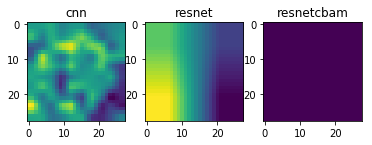

In [17]:
figure, axes = plt.subplots(1, 3)
a_type = "gradcam"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    gradcam_model = GradCAM(m, **kwargs)
    gradcam = gradcam_model.get_attribution(x, targets)
    ax.imshow(gradcam.squeeze())
    ax.set_title(m_type)
plt.show()

## GuidedGrad

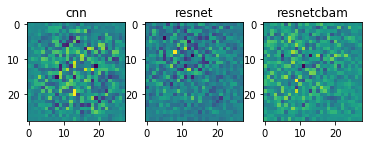

In [18]:
figure, axes = plt.subplots(1, 3)
a_type = "guidedgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    guided_model = GuidedGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## VanillaGrad

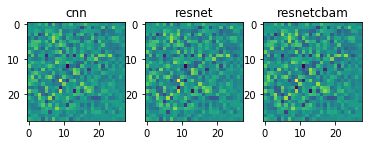

In [19]:
figure, axes = plt.subplots(1, 3)
a_type = "vanillagrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    vanillagrad = VanillaGrad(m, **kwargs)
    grad = guided_model.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## InputGrad

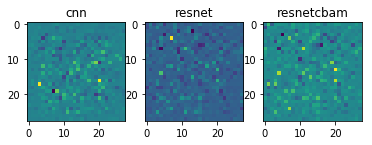

In [21]:
figure, axes = plt.subplots(1, 3)
a_type = "inputgrad"
for m_type, m, ax in zip(["cnn", "resnet", "resnetcbam"], 
                         [model, model2, model3], axes):
    kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
    gradinput = InputGrad(m, **kwargs)
    grad = gradinput.get_attribution(x, targets)
    ax.imshow(grad.squeeze())
    ax.set_title(m_type)
plt.show()

## DeconvNet

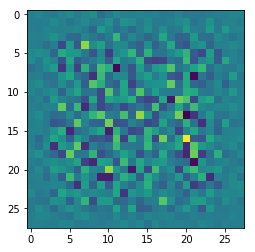

In [22]:
a_type = "deconv"
m_type = "cnn"
kwargs = get_kwargs(data_type, a_type, m_type, kwargs_packs)
deconvnet = DeconvNet(model, **kwargs)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

## LRP

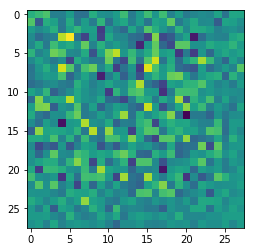

In [24]:
lrp_model = LRP(model)
lrp = lrp_model.get_attribution(x, targets)
plt.imshow(lrp.squeeze())
plt.show()